In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import time


In [2]:
#
## Parameters of the model
#
D = 373000         # SA diffusion constant [nm^2/s]
lam = 7.5          # Ligand-receptor interaction range [nm] 

k0=1.0      # scale factor for the binding and unbinding reactions between HA and SA
k_on = 1000*k0*0.56*np.pi*np.power(lam,2)   # Binding rate of HA-SA bridges [s^-1]
k_off = 1000*k0*9.0          # Unbinding rate of HA-SA bridges [s^-1]

k_d = 4000*np.pi*np.power(lam,2)     # Destruction rate of SA by NA [s^-1]
#k_d = 1000*np.pi*np.power(lam,2)
#k_d = 2000*np.pi*np.power(lam,2)

R = 60.0             # Radius of the disk [nm]
A = np.pi * np.power(R,2)
A_ref=np.pi * np.power(60.,2)

R_max = 5000.0 # 100.0*R       # Maximum radial distance for the simulation
c_HA_0 = 48./A_ref       # Uniform concentration of HA in the disk [nm^-2]
N_HA = 48.
c_NA_0 = 13./A_ref       # Uniform concentration of NA in the disk [nm^-2]
c_SA_0 = 0.03        # Initial uniform concentration of SA [nm^-2]

print('c_HA_0=',c_HA_0,'c_NA_0=',c_NA_0)


c_HA_0= 0.004244131815783876 c_NA_0= 0.0011494523667747998


Dynamic integrator

In [4]:

# Spatial grid
dr = 0.5
r = np.arange(0, R_max + dr, dr)
N = len(r)

# Initial concentrations
c_SA = np.ones_like(r) * c_SA_0  # Initial SA concentration
c_B = np.zeros_like(r)           # Initial bridge concentration

# Define indices for the disk region
inside_disk = (r <= R)
outside_disk = ~inside_disk

# Time evolution function
dt_check=1.
last_print_t = -dt_check
starting_time=time.time()
def reaction_diffusion_2D(t, y, c_HA_0, c_NA_0):
    
    global last_print_t
    if t - last_print_t >= dt_check:  # Print every 1 PDE time unit
        print(f"Solving at t = {t:.2f}", "run time = ", time.time()-starting_time)
        last_print_t = t  # Update last printed time

    c_rd_SA = y[:N]
    c_rd_B = y[N:]
    dSA_dt = np.zeros_like(c_rd_SA)
    dB_dt = np.zeros_like(c_rd_B)

    # Diffusion term for SA
    dSA_dt[1:-1] = D * (c_rd_SA[2:] - 2 * c_rd_SA[1:-1] + c_rd_SA[:-2]) / dr**2
    dSA_dt[1:-1] += D * (c_rd_SA[2:] - c_rd_SA[:-2]) / (2 * dr * r[1:-1])

    # Boundary conditions
    dSA_dt[0] = dSA_dt[1]  # Neumann BC at r=0
    dSA_dt[-1] = dSA_dt[-2]         # Neumann BC at r=R_max

    # Reaction inside the disk
    dSA_dt[inside_disk] -= k_on * (c_HA_0 - c_rd_B[inside_disk]) * c_rd_SA[inside_disk]
    dSA_dt[inside_disk] += k_off * c_rd_B[inside_disk]
    dSA_dt[inside_disk] -= k_d * c_NA_0 * c_rd_SA[inside_disk]

    dB_dt[inside_disk] += k_on * (c_HA_0 - c_rd_B[inside_disk]) * c_rd_SA[inside_disk]
    dB_dt[inside_disk] -= k_off * c_rd_B[inside_disk]

    return np.concatenate([dSA_dt, dB_dt])

# Initial state 
y0 = np.concatenate([c_SA, c_B])

# Time grid 
t_fin=0.0175
t_eval = np.linspace(0, t_fin, 1000)  # From t=0 to t=10, 100 points

# Solve the system 
solution = solve_ivp(
    reaction_diffusion_2D,
    [0, t_fin],
    y0,
    t_eval=t_eval,
    method='RK45',
    args=(c_HA_0, c_NA_0)
)

# Extract SA, B, and calculate total bridges over time
c_SA_t = solution.y[:N, :]
c_B_t = solution.y[N:, :]
N_B_t = 2 * np.pi * np.trapz(c_B_t[inside_disk, :] * r[inside_disk, None], r[inside_disk], axis=0)



Solving at t = 0.00 run time =  0.0065975189208984375


Detachment probability 

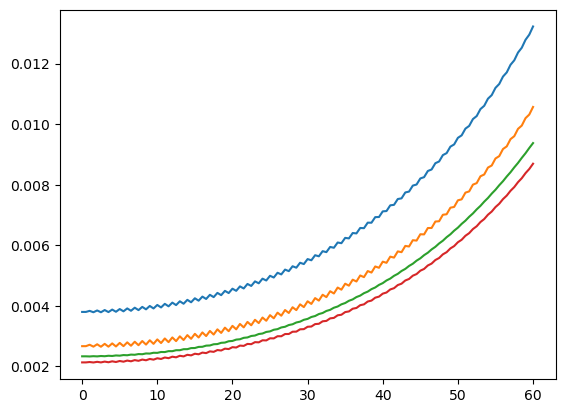

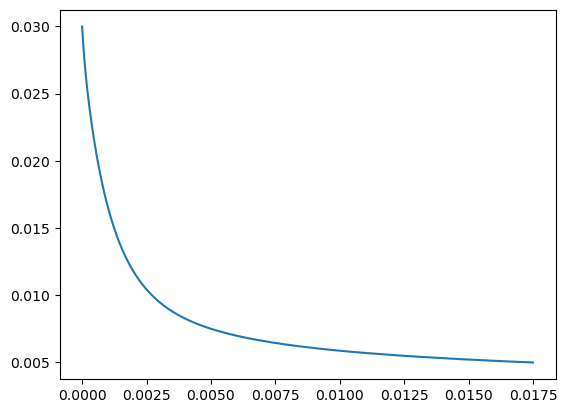

In [5]:

# building the average SA concentration inside the disk

plt.plot(r[inside_disk], c_SA_t[inside_disk, 250])
plt.plot(r[inside_disk], c_SA_t[inside_disk, 500])
plt.plot(r[inside_disk], c_SA_t[inside_disk, 750])
plt.plot(r[inside_disk], c_SA_t[inside_disk, -1])
plt.show()

c_SA_id_av=np.mean(r[inside_disk,None] * c_SA_t[inside_disk, :], axis=0)/ np.mean(r[inside_disk])

plt.plot(solution.t, c_SA_id_av)
plt.show()

The first passage equation is the following 

$T_{m,0} = \sum_{i=1}^m {1\over r_i(t)}+\sum_{i=1}^m \sum_{j=i+1}^{N_{\it HA}} {1\over r_j(t)} \prod_{k=1}^{j-1} {g_k(t) \over r_k(t)}$

We define 

$\ell_j = \prod_{k=1}^{j-1} {g_k(t) \over r_k(t)}$ with $j\geq 2$

Then 

$T_{m,0} = \sum_{i=1}^m {1\over r_i(t)}+\sum_{i=1}^m \sum_{j=i+1}^{N_{\it HA}} {\ell_j \over r_j(t)} $

We define $\tau_i = \sum_{j=i+1}^{N_{\it HA}} {\ell_j \over r_j(t)}$, then 

$T_{m,0} = \sum_{i=1}^m {1\over r_i(t)}+\sum_{i=1}^m \tau_i $

Finally the mean first passage time is calculated as 

$k^{-1}=\sum _m T_{m,0} p_m$

In [6]:

# Defining functions for the mean first passage time calculation


def comp_g(N_HA,k_on,c_SA_av):
    vec_g = k_on * c_SA_av * (N_HA - np.arange(N_HA + 1))
    return vec_g 

def comp_r(N_HA,k_off):
    vec_r = k_off * np.arange(N_HA + 1) 
    return vec_r

def pm(N_HA,g_vec,r_vec): #probability of a given number of HA-SA bridges ## TODO: this routine should be vectorized with np.cumprod
    int_N_HA = int(N_HA)
    pm_vector = np.zeros(int_N_HA + 1)
    pm_vector[0]=1.
    for i in range(1,int_N_HA + 1):
        pm_vector[i] = pm_vector[i-1] * g_vec[i-1] / r_vec[i]
    return pm_vector / np.sum(pm_vector)  # Normalize the probability mass function

# mean first passage time
def mean_fpt(N_HA, g_vec, r_vec):

    #print('g_vec=', g_vec)
    #print('r_vec=', r_vec)

    nonzero = r_vec != 0
    one_over_r = np.zeros_like(g_vec)
    one_over_r[nonzero] = 1.0 / r_vec[nonzero] 
    cumsum_one_over_r = np.cumsum(one_over_r) 
    
    #print('cumsum_one_over_r=', cumsum_one_over_r)

    g_over_r = np.ones_like(g_vec)
    g_over_r[nonzero] = g_vec[nonzero] / r_vec[nonzero]

    #print('g_over_r=', g_over_r)
    g_over_r_shifted = np.roll(g_over_r, 1)
    g_over_r_shifted[0] = 1.0
    #print('g_over_r_shifted=', g_over_r_shifted)
    ell = np.cumprod(g_over_r_shifted) 
    #print('ell=', ell)
    
    int_tau = np.zeros_like(g_vec)
    int_tau[nonzero] = ell[nonzero] / r_vec[nonzero]
    tau=np.ones_like(g_vec)*np.sum(int_tau) - np.cumsum(int_tau)
    tau[0]=0.0
    #print('tau=', tau)

    T_m0 = cumsum_one_over_r+np.cumsum(tau) 

    #print('T_m0=', T_m0)

    pm_vector = pm(N_HA, g_vec, r_vec)

    fpt = np.sum(T_m0 * pm_vector)  

    return fpt



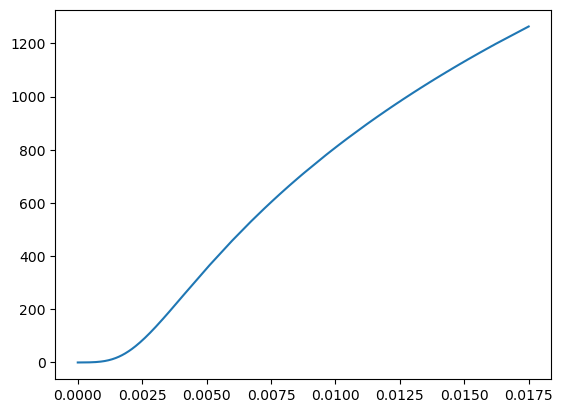

In [7]:

list_k=np.array([])

for ii, t in enumerate(solution.t):
    
    c_SA_av_act = c_SA_id_av[ii]
    g_vec = comp_g(N_HA, k_on, c_SA_av_act)
    r_vec = comp_r(N_HA, k_off)

    k_act = 1./mean_fpt(N_HA, g_vec, r_vec)
    list_k = np.append(list_k, k_act)


plt.plot(solution.t, list_k)
plt.show()

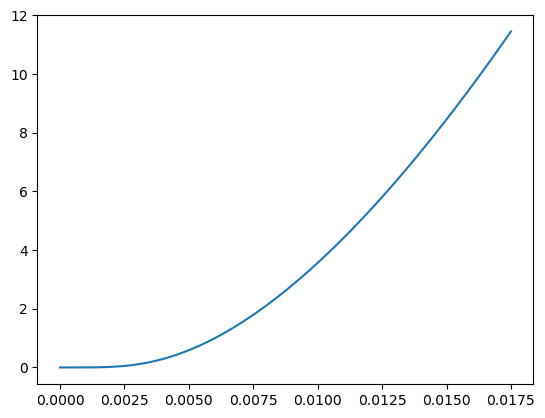

In [8]:


from scipy.integrate import cumulative_trapezoid
int_list_k = cumulative_trapezoid(list_k, solution.t, initial=0)
#plt.plot(solution.t, list_k)
plt.plot(solution.t, int_list_k)
plt.show()


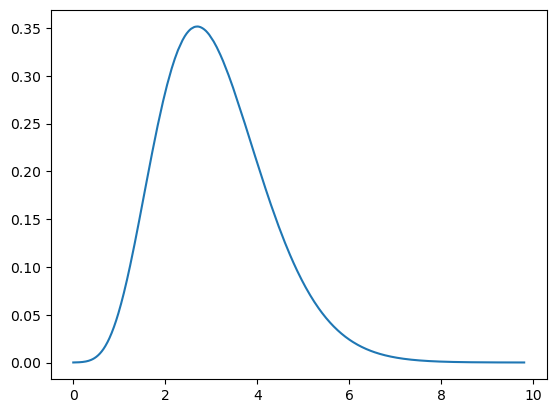

0.9999868447499275


In [10]:

vec_t_res = solution.t * 1000 * 0.56  
prob_tdet = list_k * np.exp(-int_list_k)/(1000* 0.56)  

np.save('vec_t_res_kd7.143.npy', vec_t_res)
np.save('prob_tdet_kd7.143.npy', prob_tdet)


plt.plot(vec_t_res, prob_tdet)
plt.show()

print(np.trapz(prob_tdet, vec_t_res))

Final figure

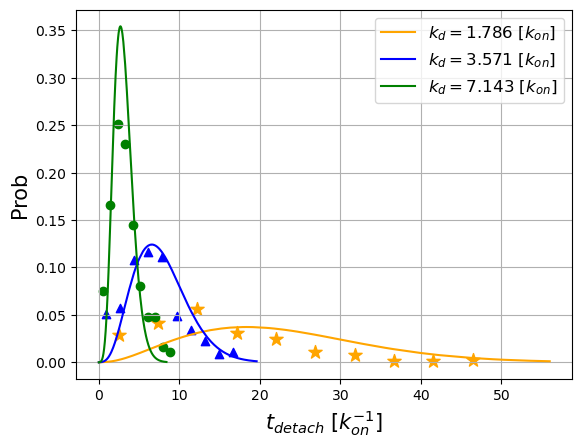

In [11]:

vec_t_res_kd3 = np.load('vec_t_res_kd3.571.npy')
prob_tdet_kd3 = np.load('prob_tdet_kd3.571.npy')
vec_t_res_kd1 = np.load('vec_t_res_kd1.786.npy')
prob_tdet_kd1 = np.load('prob_tdet_kd1.786.npy')
vec_t_res_kd7 = np.load('vec_t_res_kd7.143.npy')
prob_tdet_kd7 = np.load('prob_tdet_kd7.143.npy')

vec_t_sim_kd1 = np.load('tdet_sim_kd1.786.npy')
vec_t_sim_kd3 = np.load('tdet_sim_kd3.571.npy')
vec_t_sim_kd7 = np.load('tdet_sim_kd7.143.npy')


plt.plot(vec_t_res_kd1, prob_tdet_kd1, color='orange', label =r'$k_d=1.786$ [$k_{\it on}$]')
# Plot normalized histogram as scatter points (no rectangles)
hist_vals_kd1, bin_edges = np.histogram(vec_t_sim_kd1, bins=10, density=True)
bin_centers_kd1 = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.scatter(bin_centers_kd1, hist_vals_kd1, color='orange', marker='*', s=100)

plt.plot(vec_t_res_kd3, prob_tdet_kd3, color='blue', label =r'$k_d=3.571$ [$k_{\it on}$]')
# Plot normalized histogram as scatter points (no rectangles)
hist_vals_kd3, bin_edges = np.histogram(vec_t_sim_kd3, bins=10, density=True)
bin_centers_kd3 = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.scatter(bin_centers_kd3, hist_vals_kd3, color='blue', marker='^')

plt.plot(vec_t_res_kd7, prob_tdet_kd7, color='green', label =r'$k_d=7.143$ [$k_{\it on}$]')
# Plot normalized histogram as scatter points (no rectangles)
hist_vals_kd7, bin_edges = np.histogram(vec_t_sim_kd7, bins=10, density=True)
bin_centers_kd7 = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.scatter(bin_centers_kd7, hist_vals_kd7, color='green', marker='o')

plt.grid()
plt.xlabel(r'$t_{\it detach}$ [$k_{\it on}^{-1}$]', fontsize=15)
plt.ylabel('Prob', fontsize=15)
plt.legend(fontsize=12)
plt.show()

